<a href="https://colab.research.google.com/github/ElpoderdelComputo/Tutoriales_YouTube/blob/main/Sel_caracteristicas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SELECCIÓN DE CARACTERISTICAS**

In [1]:
#Importamos librerias
import pandas as pd
import numpy as np

''' El conjunto de datos de Wine es otro conjunto de datos de código abierto que está disponible
en el repositorio de aprendizaje automático de la UCI (https://archive.ics.uci.edu/ml/datasets/Wine);
consta de 178 muestras de vino con 13 características que describen sus diferentes propiedades químicas. '''

#Cargaos datos de vinos
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)


In [2]:
# Agregamos etiquetas para mostrar columnas y etiquetas
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# division de 70% de muestras para entrenamiento y 30% para test
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=0,
                                                    stratify=y)

# Mostrar cuantos datos hay en total: en entrenamiento y prueba
print('\nNumero de etiquetas en y:', np.bincount(y))
print('Numero de etiquetas en y_train:', np.bincount(y_train))
print('Numero de etiquetas en y_test:', np.bincount(y_test))

# Estandarizar los datos
stdsc = StandardScaler()

X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)


Numero de etiquetas en y: [ 0 59 71 48]
Numero de etiquetas en y_train: [ 0 41 50 33]
Numero de etiquetas en y_test: [ 0 18 21 15]


**La Selección Secuencial hacia Atrás (SBS) es un método clásico para reducir la cantidad de características en un conjunto de datos. Su objetivo es disminuir la complejidad del conjunto de características original con la menor pérdida posible de rendimiento en el clasificador, todo esto para hacer más eficiente el proceso computacional.

La idea detrás de SBS es ir eliminando características una a una del conjunto completo hasta que se logre alcanzar la cantidad deseada de características en el nuevo conjunto resultante.**

In [10]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):

        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train,
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [11]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

#usamos vecinos cercanos con k= 5
knn = KNeighborsClassifier(n_neighbors=5)

# seleccionando caracteristicas
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

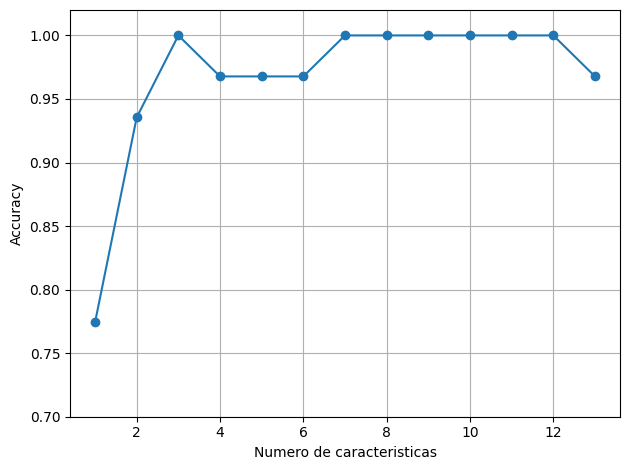

In [12]:
# Representación gráfica del rendimiento de los subconjuntos de entidades
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Numero de caracteristicas')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

In [13]:
#Subconjunto de características más pequeño (k=3) que produjo un rendimiento tan bueno en el conjunto de datos de validación.

k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


In [14]:
# A continuación, evaluemos el rendimiento del clasificador KNN en el conjunto de prueba original

knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.967741935483871
Test accuracy: 0.9629629629629629


In [15]:
# Ahora, usemos el subconjunto de tres características seleccionado y veamos qué tan bien se desempeña KNN

knn.fit(X_train_std[:, k3], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

Training accuracy: 0.9516129032258065
Test accuracy: 0.9259259259259259


# Evaluación de la importancia de las características con bosques aleatorios

**Usando un bosque aleatorio, podemos medir la importancia de la característica como la disminución promedio de impurezas calculada a partir de todos los árboles de decisión en el bosque, sin hacer suposiciones sobre si nuestros datos son linealmente separables o no.**

Importancia de todas las características:
 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


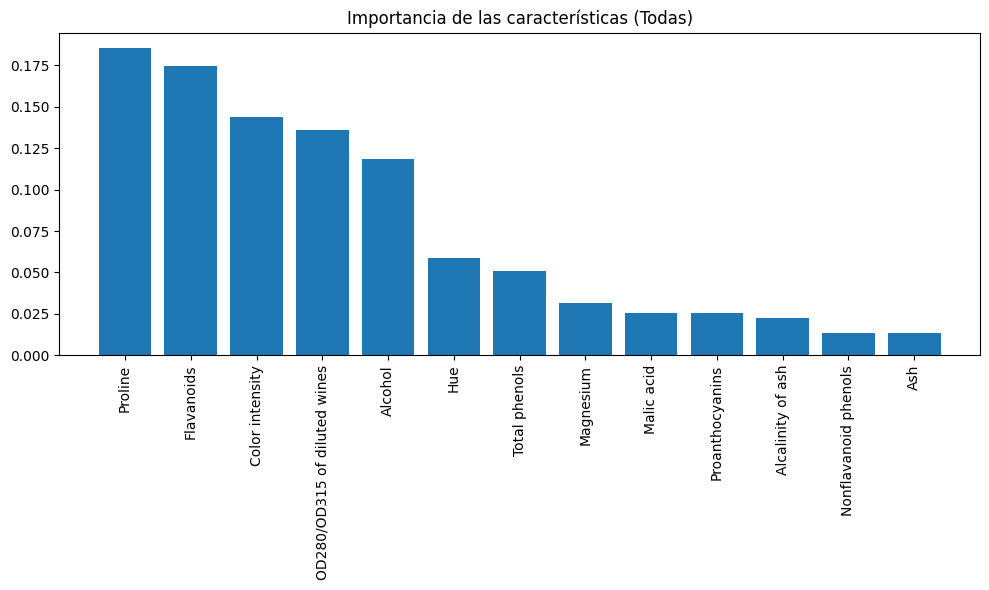

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt

feat_labels = df_wine.columns[1:]

# Definimos el clasificador con 13 características
forest_all_features = RandomForestClassifier(n_estimators=500, random_state=1)
forest_all_features.fit(X_train, y_train)

# Imprimimos la importancia de todas las características
print("Importancia de todas las características:")

importances = forest_all_features.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))

# Graficamos la importancia de las características
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center')
plt.title('Importancia de las características (Todas)')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [29]:
# Seleccionamos las 5 mejores características con criterio de umbral threshold= 0.1

sfm = SelectFromModel(forest_all_features, threshold=0.1, prefit=True)
X_selected_all_features = sfm.transform(X_train)

# Imprimimos la cantidad de muestras que cumplen el criterio
print('\nNúmero de muestras que cumplen el criterio (Todas las características):',
      X_selected_all_features.shape[0])


Número de muestras que cumplen el criterio (Todas las características): 124
